# Ramping analysis
## Simple script to open JSON and pickle data

In [1]:
import jpype
jpype.startJVM(jpype.getDefaultJVMPath())

In [2]:
from cpymad.madx import Madx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import glob
import json
import pybt
from pybt.tools.parsers import read_twiss_file
from pybt.myjson.encoder import myJSONDecoder
from os import walk
import skimage
from skimage import filters
from scipy import integrate
from matplotlib.pyplot import cm
import pickle
from scipy.optimize import curve_fit

def gaussian_function(x, a, I, mu, sig):
    return a + I / np.sqrt(2 * np.pi * sig ** 2) * np.exp(-(x - mu) ** 2 / 2. / sig ** 2)

def do_gaussian_fit(x,y):
    mu = np.average(x, weights=np.abs(y - np.min(y)))
    sigma = np.sqrt(np.average(x**2, weights=np.abs(y - np.min(y))) - mu**2)
    p0 = [y.min(), (np.max(y) - np.min(y)) * np.sqrt(2 * np.pi * sigma**2), mu, sigma]
    popt, pcov = curve_fit(gaussian_function, x, y, p0=p0, maxfev=1000) # maxfev is the number of tries it does the fit
    return popt, pcov

def create_elliptical_mask(h, w, center=None, radius=None, a=None, b=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt( ((X - center[0])**2)/(a**2) + ((Y-center[1])**2)/(b**2) )

    mask = dist_from_center <= radius
    return mask

# Create a Dataframe will all data

In [111]:
start_path = "/eos/user/e/eljohnso/SWAN_projects/quad-scan-east"
end_path = "data_east_dump_ramping/"
mypath = start_path+"/"+end_path

f = []
for (dirpath, dirnames, filenames) in walk(mypath):
    f.extend(filenames)
    break

In [112]:
dirnames

['data_east_dump_no_rampingF61D.BTV010_filter_3_2022_06_28_14h55m56s',
 'data_east_dump_rampingF61D.BTV010_filter_3_2022_06_28_14h15m39s']

In [113]:
btv_name = "F61D.BTV010"
df = pd.DataFrame(data = {"Image": [], "Image_processed": [], "Acqu": [], "Intensity": [], "Filter": [], "sigmaSet1": [], "ramping": []})
for dirname in dirnames:
    print (dirname)
    infile = open("data_east_dump_ramping/"+dirname+"/"+dirname+".p", 'rb')
    loaded_pickle = pickle.load(infile)
    
    pixel_y = len(loaded_pickle[1][btv_name][0]["imagePositionSet2"][0])

    for j in range(len(loaded_pickle[0])):
        for i in range(6):
            image = loaded_pickle[1][btv_name][j]["imageSet"][i]
            reshaped_image = image.reshape(pixel_y,-1)
            reshaped_image = reshaped_image/4095 #Normalize
            med_filter_image = filters.median(reshaped_image, np.ones((3, 3)))
            if (dirname == "data_east_dump_no_rampingF61D.BTV010_filter_3_2022_06_28_14h55m56s"):
                ramping_state = "no_ramping"
            if (dirname == "data_east_dump_rampingF61D.BTV010_filter_3_2022_06_28_14h15m39s"):
                ramping_state = "ramping"
            df2 = pd.DataFrame(data = {"Image": [reshaped_image], "Image_processed": [med_filter_image], "Acqu": [i], "Intensity": [loaded_pickle[3][j]], "Filter": [loaded_pickle[1][btv_name][j]["filterSelect"][1]],
                                       "sigmaSet1": loaded_pickle[2][btv_name][j]["sigmaSet1"][i],
                                       "ramping": ramping_state,
                                      })
            df = pd.concat([df,df2])
df.reset_index(drop=True, inplace=True)

# Add saturation colum
saturation_list = []
for i in range(len(df)):
    saturation_list.append((df.iloc[i].Image == 1).sum())
df["Saturation"] = saturation_list
saturation_list = []
for i in range(len(df)):
    saturation_list.append((df.iloc[i].Image_processed == 255).sum())
df["Saturation_processed"] = saturation_list
    
df.head(5)

data_east_dump_no_rampingF61D.BTV010_filter_3_2022_06_28_14h55m56s


/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/skimage/util/dtype.py:140: UserWarning: Possible precision loss when converting from float64 to uint8
  warn("Possible precision loss when converting from {} to {}"


data_east_dump_rampingF61D.BTV010_filter_3_2022_06_28_14h15m39s


Image  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
3  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
4  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                     Image_processed  Acqu  Intensity Filter  \
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   0.0  19.839317  THIRD   
1  [[1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1,...   1.0  19.839317  THIRD   
2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   2.0  19.839317  THIRD   
3  [[2, 0, 0, 0, 0, 0, 0, 0, 4, 6, 0, 0, 0, 0, 0,...   3.0  19.839317  THIRD   
4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   4.0  19.839317  THIRD   

   sigmaSet1     ramping  Saturation  Saturation_processed  
0   6.255548  no_ramping           0                     0  
1   1.805804  no_ramping           0                     0  
2   1.696808  no_ramping           8                     0  
3   1.144019  no_ramping           6                     0  
4   1.350510  no_ramping           9                     0

## Add fit for Image_processed

In [115]:
# Add fitting colums
gaussian_maxH_list = []
gaussian_maxV_list = []

poptH0_list = []
poptH1_list = []
poptH2_list = []
poptH3_list = []

poptV0_list = []
poptV1_list = []
poptV2_list = []
poptV3_list = []

muH_list = []
muH_err_list = []
muV_list = []
muV_err_list = []

sigH_list = []
sigH_err_list = []
sigV_list = []
sigV_err_list = []

integralH_list = []
integralV_list = []


for i in range(len(df)):

    try:
        Image_processed = df.iloc[i].Image_processed.copy()

        Hy = Image_processed.sum(axis=0)
        Hx = np.linspace(0, len(Hy)-1, len(Hy))

        Vy = Image_processed.sum(axis=1)
        Vx = np.linspace(0, len(Vy)-1, len(Vy))

        # H
        poptH, pcovH = do_gaussian_fit(Hx, Hy)

        gaussian_maxH = gaussian_function(Hx, poptH[0], poptH[1], poptH[2], poptH[3]).max()

        # V
        poptV, pcovV = do_gaussian_fit(Vx, Vy)

        gaussian_maxV = gaussian_function(Vx, poptV[0], poptV[1], poptV[2], poptV[3]).max()

        gaussian_maxH_list.append(gaussian_maxH)
        gaussian_maxV_list.append(gaussian_maxV)
        
        poptH0_list.append(poptH[0])
        poptH1_list.append(poptH[1])
        poptH2_list.append(poptH[2])
        poptH3_list.append(poptH[3])
        
        poptV0_list.append(poptV[0])
        poptV1_list.append(poptV[1])
        poptV2_list.append(poptV[2])
        poptV3_list.append(poptV[3])

        
        muH_list.append(poptH[2])
        muH_err_list.append(pcovH[2, 2] ** 0.5)
        muV_list.append(poptV[2])
        muV_err_list.append(pcovV[2, 2] ** 0.5)
        
        sigH_list.append(poptH[3])
        sigH_err_list.append(pcovH[3, 3] ** 0.5)
        sigV_list.append(poptV[3])
        sigV_err_list.append(pcovV[3, 3] ** 0.5)
        
        try:
            #Integration
            x = np.linspace(0,300,300)
            gaussH = lambda x: gaussian_function(x, poptH[0], poptH[1], poptH[2], poptH[3])
            integralH = (integrate.quad(gaussH, 0, 300))

            gaussV = lambda x: gaussian_function(x, poptV[0], poptV[1], poptV[2], poptV[3])
            integralV = (integrate.quad(gaussV, 0, 300))

            integralH_list.append(integralH[0])
            integralV_list.append(integralV[0])
        except:
            print("failed integration")
            pass
            
        
    except:
        gaussian_maxH_list.append(np.nan)
        gaussian_maxV_list.append(np.nan)

        poptH0_list.append(np.nan)
        poptH1_list.append(np.nan)
        poptH2_list.append(np.nan)
        poptH3_list.append(np.nan)
        
        poptV0_list.append(np.nan)
        poptV1_list.append(np.nan)
        poptV2_list.append(np.nan)
        poptV3_list.append(np.nan)
        
        muH_list.append(np.nan)
        muH_err_list.append(np.nan)
        muV_list.append(np.nan)
        muV_err_list.append(np.nan)
        
        sigH_list.append(np.nan)
        sigH_err_list.append(np.nan)
        sigV_list.append(np.nan)
        sigV_err_list.append(np.nan)
        
        integralH_list.append(np.nan)
        integralV_list.append(np.nan)
#         print("Failed fit")

# df["gaussian_maxH_proc"] = gaussian_maxH_list
# df["gaussian_maxV_proc"] = gaussian_maxV_list

# df["poptH0_proc"] = poptH0_list
# df["poptH1_proc"] = poptH1_list
# df["poptH2_proc"] = poptH2_list
# df["poptH3_proc"] = poptH3_list
df["muH_proc"] = muH_list
# df["muErrH_proc"] = muH_err_list
df["sigH_proc"] = sigH_list
# df["sigErrH_proc"] = sigH_err_list


# df["poptV0_proc"] = poptV0_list
# df["poptV1_proc"] = poptV1_list
# df["poptV2_proc"] = poptV2_list
# df["poptV3_proc"] = poptV3_list
df["muV_proc"] = muV_list
# df["muErrV_proc"] = muV_err_list
df["sigV_proc"] = sigV_list
# df["sigErrV_proc"] = sigV_err_list

# df["integralH_proc"] = integralH_list
# df["integralV_proc"] = integralV_list
print (f"{len(df[np.isnan(df.muH_proc)].muH_proc)}/{len(df)} failed fit")

print (f"muH: {int(df.muH_proc.median())}")
print (f"muV: {int(df.muV_proc.median())}")
print (f"sigH: {int(df.sigH_proc.median())}")
print (f"sigV: {int(df.sigV_proc.median())}")

/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


283/300 failed fit
muH: 220
muV: -31
sigH: 3
sigV: 30


### Add a column with masked processed image using the median of the fit on the processed image to feed the ellipse center and radii

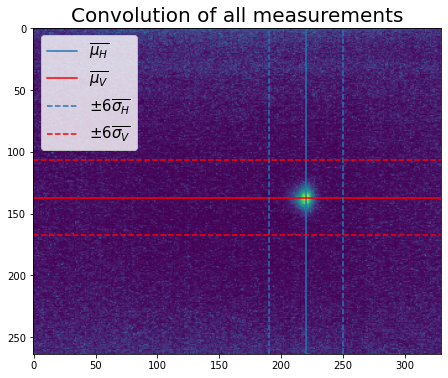

In [116]:
sum_image = np.zeros(shape=(264, 330))
for i in range(len(df)):
    sum_image = sum_image + df.iloc[i].Image
fig, ax = plt.subplots(figsize=(10,6))
ax.imshow(sum_image)

#Override

muH_median = 220
muV_median = 137
sigH_median = 5
sigV_median = 5

ax.axvline(muH_median, label = "$\overline{\mu_{H}}$")
ax.axhline(muV_median, color="r", label = "$\overline{\mu_{V}}$")

ax.axvline(muH_median + 6*sigH_median, linestyle="--", label="$\pm6\overline{\sigma_{H}}$")
ax.axvline(muH_median - 6*sigH_median, linestyle="--")

ax.axhline(muV_median + 6*sigV_median, linestyle="--", color="r", label="$\pm6\overline{\sigma_{V}}$")
ax.axhline(muV_median - 6*sigV_median, linestyle="--", color="r")
ax.set_title("Convolution of all measurements", fontsize=20)
ax.legend(fontsize=15)

In [117]:
# Add masked colum
image_processed_masked_list = []
for i in range(len(df)):
    
    image_processed_masked = df.iloc[i].Image_processed.copy()
    
    h, w = image_processed_masked.shape[:2]
    mask = create_elliptical_mask(h, w, center=(220,137), radius = 1, a=6*5, b=6*5)
    masked_img = image_processed_masked.copy()
    masked_img[~mask] = 0

    image_processed_masked_list.append(masked_img)
    
df["Image_processed_masked"] = image_processed_masked_list
df.head(1)

Image  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                     Image_processed  Acqu  Intensity Filter  \
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   0.0  19.839317  THIRD   

   sigmaSet1     ramping  Saturation  Saturation_processed  muH_proc  \
0   6.255548  no_ramping           0                     0       NaN   

   sigH_proc  muV_proc  sigV_proc  \
0        NaN       NaN        NaN   

                              Image_processed_masked  
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...

Text(0.5, 1.0, 'Masked image')

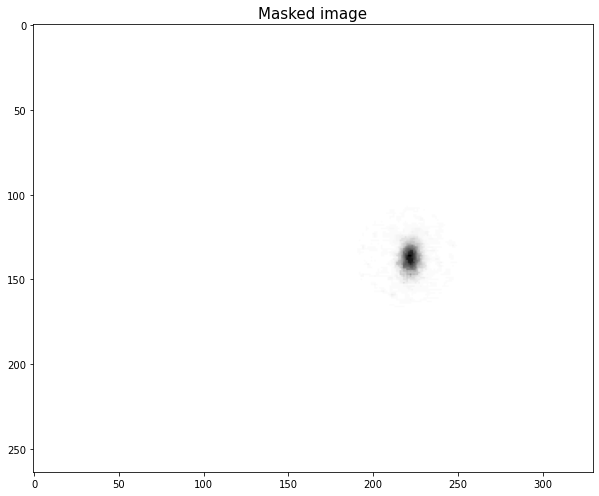

In [118]:
fig, ax = plt.subplots(figsize=(10,7),tight_layout=True)
ax.imshow(df.Image_processed_masked[8], cmap = "Greys")
ax.set_title("Masked image", fontsize=15)

Text(0.5, 1.0, 'Masked image')

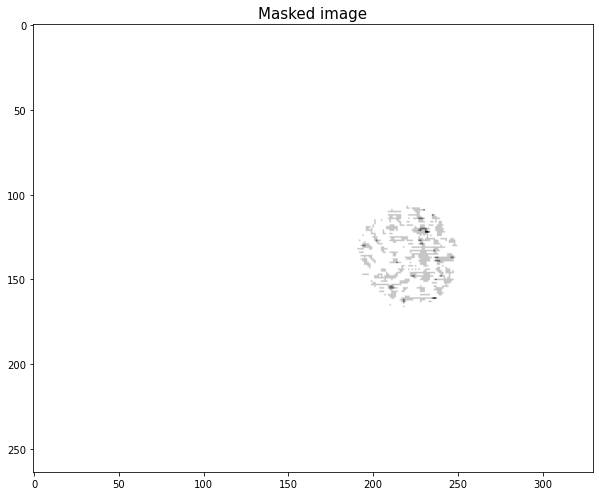

In [119]:
fig, ax = plt.subplots(figsize=(10,7),tight_layout=True)
ax.imshow(df.Image_processed_masked[0], cmap = "Greys")
ax.set_title("Masked image", fontsize=15)

## Add fit for Image_processed_masked

In [120]:
# Add fitting colums
gaussian_maxH_list = []
gaussian_maxV_list = []

poptH0_list = []
poptH1_list = []
poptH2_list = []
poptH3_list = []

poptV0_list = []
poptV1_list = []
poptV2_list = []
poptV3_list = []

muH_list = []
muH_err_list = []
muV_list = []
muV_err_list = []

sigH_list = []
sigH_err_list = []
sigV_list = []
sigV_err_list = []

integralH_list = []
integralV_list = []


for i in range(len(df)):

    try:
        image_processed_masked = df.iloc[i].Image_processed_masked.copy()

        Hy = image_processed_masked.sum(axis=0)
        Hx = np.linspace(0, len(Hy)-1, len(Hy))

        Vy = image_processed_masked.sum(axis=1)
        Vx = np.linspace(0, len(Vy)-1, len(Vy))

        # H
        poptH, pcovH = do_gaussian_fit(Hx, Hy)

        gaussian_maxH = gaussian_function(Hx, poptH[0], poptH[1], poptH[2], poptH[3]).max()

        # V
        poptV, pcovV = do_gaussian_fit(Vx, Vy)

        gaussian_maxV = gaussian_function(Vx, poptV[0], poptV[1], poptV[2], poptV[3]).max()

        gaussian_maxH_list.append(gaussian_maxH)
        gaussian_maxV_list.append(gaussian_maxV)
        
        poptH0_list.append(poptH[0])
        poptH1_list.append(poptH[1])
        poptH2_list.append(poptH[2])
        poptH3_list.append(poptH[3])
        
        poptV0_list.append(poptV[0])
        poptV1_list.append(poptV[1])
        poptV2_list.append(poptV[2])
        poptV3_list.append(poptV[3])

        
        muH_list.append(poptH[2])
        muH_err_list.append(pcovH[2, 2] ** 0.5)
        muV_list.append(poptV[2])
        muV_err_list.append(pcovV[2, 2] ** 0.5)
        
        sigH_list.append(poptH[3])
        sigH_err_list.append(pcovH[3, 3] ** 0.5)
        sigV_list.append(poptV[3])
        sigV_err_list.append(pcovV[3, 3] ** 0.5)
        
        try:
            #Integration
            x = np.linspace(-300,300,300)
            gaussH = lambda x: gaussian_function(x, poptH[0], poptH[1], poptH[2], poptH[3])
            integralH = (integrate.quad(gaussH, -300, 300))

            gaussV = lambda x: gaussian_function(x, poptV[0], poptV[1], poptV[2], poptV[3])
            integralV = (integrate.quad(gaussV, -300, 300))

            integralH_list.append(integralH[0])
            integralV_list.append(integralV[0])
        except:
            print("failed integration")
            pass
            
        
    except:
        gaussian_maxH_list.append(np.nan)
        gaussian_maxV_list.append(np.nan)

        poptH0_list.append(np.nan)
        poptH1_list.append(np.nan)
        poptH2_list.append(np.nan)
        poptH3_list.append(np.nan)
        
        poptV0_list.append(np.nan)
        poptV1_list.append(np.nan)
        poptV2_list.append(np.nan)
        poptV3_list.append(np.nan)
        
        muH_list.append(np.nan)
        muH_err_list.append(np.nan)
        muV_list.append(np.nan)
        muV_err_list.append(np.nan)
        
        sigH_list.append(np.nan)
        sigH_err_list.append(np.nan)
        sigV_list.append(np.nan)
        sigV_err_list.append(np.nan)
        
        integralH_list.append(np.nan)
        integralV_list.append(np.nan)
        print("Failed fit")

df["gaussian_maxH"] = gaussian_maxH_list
df["gaussian_maxV"] = gaussian_maxV_list

df["poptH0"] = poptH0_list
df["poptH1"] = poptH1_list
df["poptH2"] = poptH2_list
df["poptH3"] = poptH3_list
df["muH"] = muH_list
df["muErrH"] = muH_err_list
df["sigH"] = sigH_list
df["sigErrH"] = sigH_err_list


df["poptV0"] = poptV0_list
df["poptV1"] = poptV1_list
df["poptV2"] = poptV2_list
df["poptV3"] = poptV3_list
df["muV"] = muV_list
df["muErrV"] = muV_err_list
df["sigV"] = sigV_list
df["sigErrV"] = sigV_err_list

df["integralH"] = integralH_list
df["integralV"] = integralV_list

print (f"{len(df[np.isnan(df.muH)].muH_proc)}/{len(df)} failed fit")

/tmp/ipykernel_526/3399877406.py:21: RuntimeWarning: invalid value encountered in double_scalars
  return a + I / np.sqrt(2 * np.pi * sig ** 2) * np.exp(-(x - mu) ** 2 / 2. / sig ** 2)
/tmp/ipykernel_526/3399877406.py:21: RuntimeWarning: divide by zero encountered in true_divide
  return a + I / np.sqrt(2 * np.pi * sig ** 2) * np.exp(-(x - mu) ** 2 / 2. / sig ** 2)
/tmp/ipykernel_526/3399877406.py:21: RuntimeWarning: invalid value encountered in true_divide
  return a + I / np.sqrt(2 * np.pi * sig ** 2) * np.exp(-(x - mu) ** 2 / 2. / sig ** 2)
/tmp/ipykernel_526/3399877406.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  return a + I / np.sqrt(2 * np.pi * sig ** 2) * np.exp(-(x - mu) ** 2 / 2. / sig ** 2)
/tmp/ipykernel_526/3399877406.py:21: RuntimeWarning: invalid value encountered in multiply
  return a + I / np.sqrt(2 * np.pi * sig ** 2) * np.exp(-(x - mu) ** 2 / 2. / sig ** 2)
/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-p

Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
6/300 failed fit


# Fit with pixel calibration

In [121]:
# Add fitting colums
gaussian_maxH_list = []
gaussian_maxV_list = []

poptH0_list = []
poptH1_list = []
poptH2_list = []
poptH3_list = []

poptV0_list = []
poptV1_list = []
poptV2_list = []
poptV3_list = []

muH_list = []
muH_err_list = []
muV_list = []
muV_err_list = []

sigH_list = []
sigH_err_list = []
sigV_list = []
sigV_err_list = []

integralH_list = []
integralV_list = []


for i in range(len(df)):

    try:
        image_processed_masked = df.iloc[i].Image_processed_masked.copy()

        Hy = image_processed_masked.sum(axis=0)
        Hx = np.linspace(min(loaded_pickle[2][btv_name][0]["projPositionSet1"][0]), max(loaded_pickle[2][btv_name][0]["projPositionSet1"][0]), len(image_processed_masked.sum(axis=0))) # Pixel calibration

        Vy = image_processed_masked.sum(axis=1)
        Vx = np.linspace(min(loaded_pickle[2][btv_name][0]["projPositionSet2"][0]), max(loaded_pickle[2][btv_name][0]["projPositionSet2"][0]), len(image_processed_masked.sum(axis=1)))

        # H
        poptH, pcovH = do_gaussian_fit(Hx, Hy)

        gaussian_maxH = gaussian_function(Hx, poptH[0], poptH[1], poptH[2], poptH[3]).max()

        # V
        poptV, pcovV = do_gaussian_fit(Vx, Vy)

        gaussian_maxV = gaussian_function(Vx, poptV[0], poptV[1], poptV[2], poptV[3]).max()

        gaussian_maxH_list.append(gaussian_maxH)
        gaussian_maxV_list.append(gaussian_maxV)
        
        poptH0_list.append(poptH[0])
        poptH1_list.append(poptH[1])
        poptH2_list.append(poptH[2])
        poptH3_list.append(poptH[3])
        
        poptV0_list.append(poptV[0])
        poptV1_list.append(poptV[1])
        poptV2_list.append(poptV[2])
        poptV3_list.append(poptV[3])

        
        muH_list.append(poptH[2])
        muH_err_list.append(pcovH[2, 2] ** 0.5)
        muV_list.append(poptV[2])
        muV_err_list.append(pcovV[2, 2] ** 0.5)
        
        sigH_list.append(poptH[3])
        sigH_err_list.append(pcovH[3, 3] ** 0.5)
        sigV_list.append(poptV[3])
        sigV_err_list.append(pcovV[3, 3] ** 0.5)
        
        try:
            #Integration
            x = np.linspace(-300,300,300)
            gaussH = lambda x: gaussian_function(x, poptH[0], poptH[1], poptH[2], poptH[3])
            integralH = (integrate.quad(gaussH, -300, 300))

            gaussV = lambda x: gaussian_function(x, poptV[0], poptV[1], poptV[2], poptV[3])
            integralV = (integrate.quad(gaussV, -300, 300))

            integralH_list.append(integralH[0])
            integralV_list.append(integralV[0])
        except:
            print("failed integration")
            pass
            
        
    except:
        gaussian_maxH_list.append(np.nan)
        gaussian_maxV_list.append(np.nan)

        poptH0_list.append(np.nan)
        poptH1_list.append(np.nan)
        poptH2_list.append(np.nan)
        poptH3_list.append(np.nan)
        
        poptV0_list.append(np.nan)
        poptV1_list.append(np.nan)
        poptV2_list.append(np.nan)
        poptV3_list.append(np.nan)
        
        muH_list.append(np.nan)
        muH_err_list.append(np.nan)
        muV_list.append(np.nan)
        muV_err_list.append(np.nan)
        
        sigH_list.append(np.nan)
        sigH_err_list.append(np.nan)
        sigV_list.append(np.nan)
        sigV_err_list.append(np.nan)
        
        integralH_list.append(np.nan)
        integralV_list.append(np.nan)
        print("Failed fit")

# df["gaussian_maxH"] = gaussian_maxH_list
# df["gaussian_maxV"] = gaussian_maxV_list

df["poptH0_cal"] = poptH0_list
df["poptH1_cal"] = poptH1_list
df["poptH2_cal"] = poptH2_list
df["poptH3_cal"] = poptH3_list
# df["muH"] = muH_list
# df["muErrH"] = muH_err_list
# df["sigH"] = sigH_list
df["sigErrH_cal"] = sigH_err_list


df["poptV0_cal"] = poptV0_list
df["poptV1_cal"] = poptV1_list
df["poptV2_cal"] = poptV2_list
df["poptV3_cal"] = poptV3_list
# df["muV"] = muV_list
# df["muErrV"] = muV_err_list
# df["sigV"] = sigV_list
df["sigErrV_cal"] = sigV_err_list

# df["integralH"] = integralH_list
# df["integralV"] = integralV_list

/tmp/ipykernel_526/3399877406.py:21: RuntimeWarning: invalid value encountered in double_scalars
  return a + I / np.sqrt(2 * np.pi * sig ** 2) * np.exp(-(x - mu) ** 2 / 2. / sig ** 2)
/tmp/ipykernel_526/3399877406.py:21: RuntimeWarning: divide by zero encountered in true_divide
  return a + I / np.sqrt(2 * np.pi * sig ** 2) * np.exp(-(x - mu) ** 2 / 2. / sig ** 2)
/tmp/ipykernel_526/3399877406.py:21: RuntimeWarning: invalid value encountered in true_divide
  return a + I / np.sqrt(2 * np.pi * sig ** 2) * np.exp(-(x - mu) ** 2 / 2. / sig ** 2)
/tmp/ipykernel_526/3399877406.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  return a + I / np.sqrt(2 * np.pi * sig ** 2) * np.exp(-(x - mu) ** 2 / 2. / sig ** 2)
/tmp/ipykernel_526/3399877406.py:21: RuntimeWarning: invalid value encountered in multiply
  return a + I / np.sqrt(2 * np.pi * sig ** 2) * np.exp(-(x - mu) ** 2 / 2. / sig ** 2)
/tmp/ipykernel_526/2383814101.py:78: IntegrationWarning: The occurrence of roundoff e

Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit


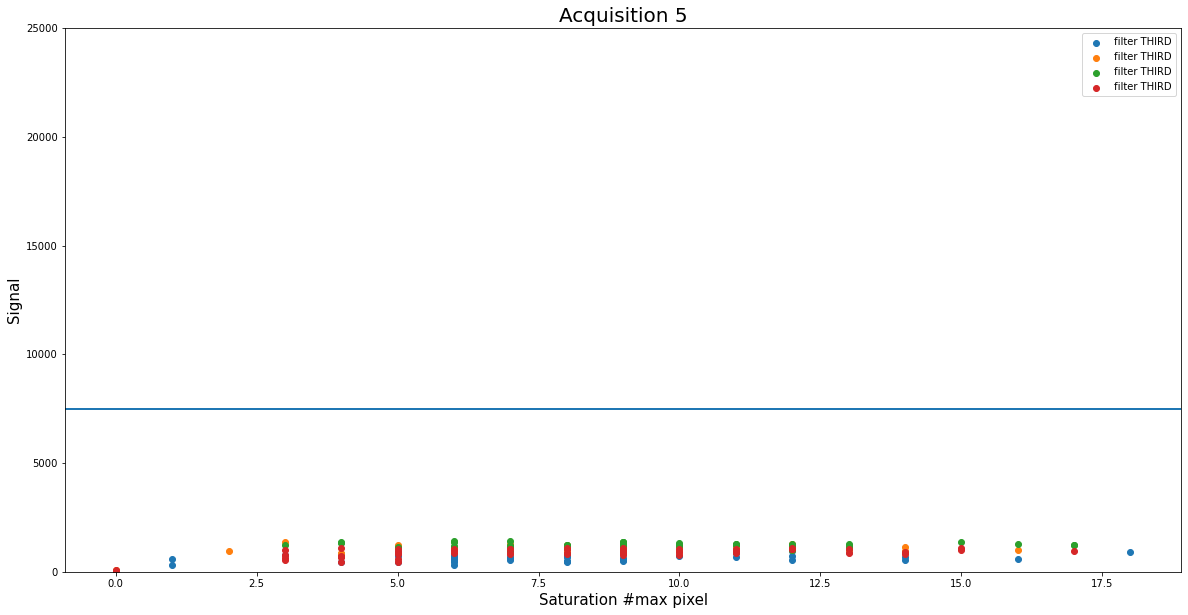

In [122]:
fig, ax = plt.subplots(figsize=(20,10))

for Acqu in range(4):
    Acqu=Acqu+2

    for Filter in ["THIRD"]:
            
        Saturation = df[df.Filter==Filter][df[df.Filter==Filter].Acqu==Acqu].Saturation
        SignalH = df[df.Filter==Filter][df[df.Filter==Filter].Acqu==Acqu].gaussian_maxH
        SignalV = df[df.Filter==Filter][df[df.Filter==Filter].Acqu==Acqu].gaussian_maxV
        Intensity = df[df.Filter==Filter][df[df.Filter==Filter].Acqu==Acqu].Intensity

        ax.scatter(Saturation, SignalH+SignalV, label=f"filter {Filter}")

    ax.set_title(f"Acquisition {Acqu}", fontsize=20)
    ax.legend()
    ax.set_xlabel("Saturation #max pixel", fontsize=15)
    ax.set_ylabel("Signal", fontsize=15)
    ax.set_ylim(0, 25000)
    ax.axhline(7500)

# Image processing

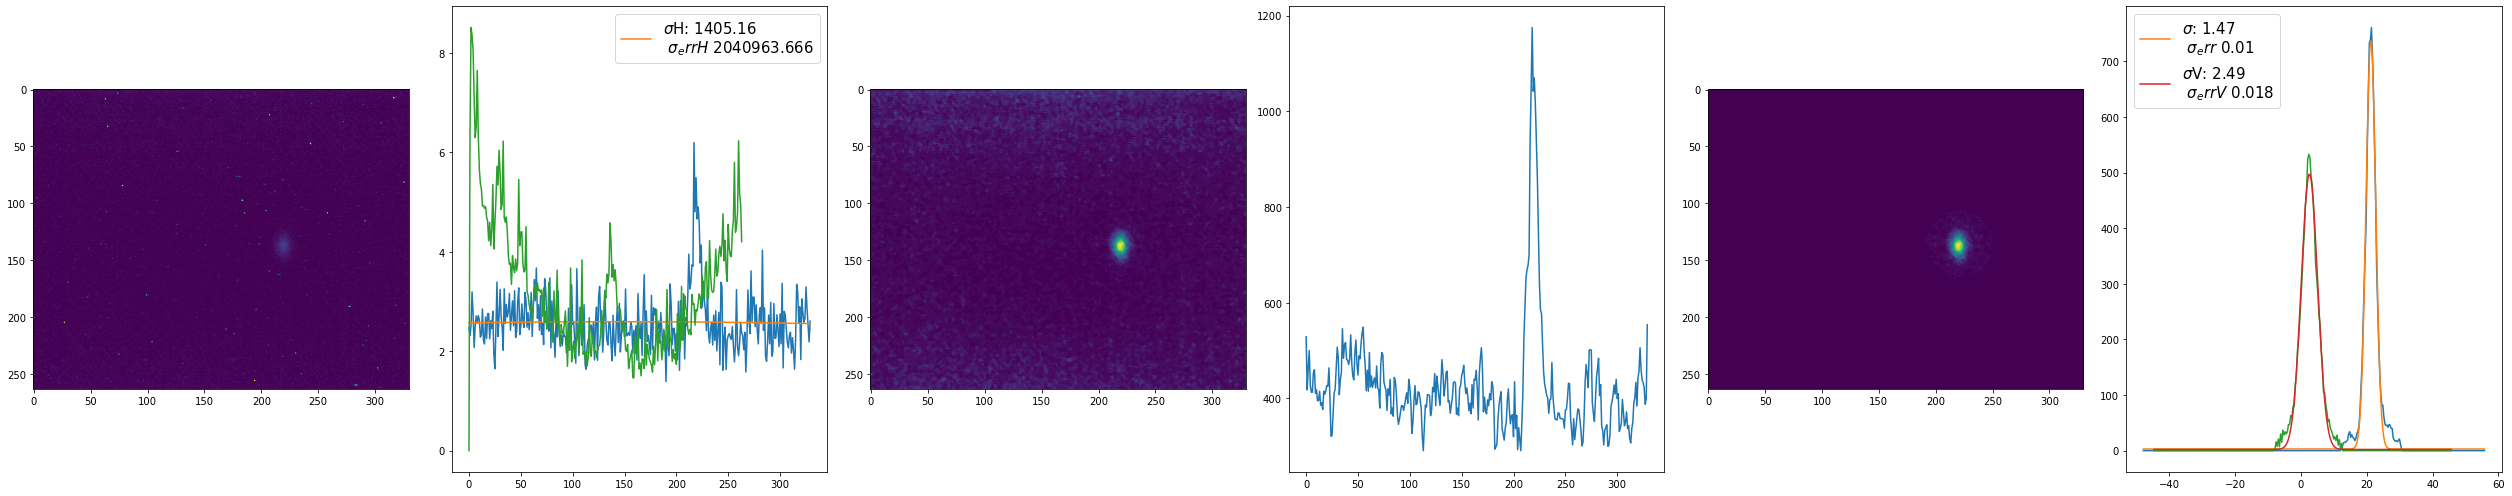

In [123]:
dff3 = df[df.Filter=="THIRD"].copy()
dff3a4 = dff3[dff3.Acqu==4].copy()
for i in range(1):
    try:
        fig, ax = plt.subplots(1,6, figsize=(35,7), tight_layout=True)

        # Raw image
        ax[0].imshow(dff3a4.iloc[i].Image)

        Hy = dff3a4.iloc[i].Image.sum(axis=0)
        Hx = np.linspace(0, len(Hy)-1, len(Hy))

        try:
            ax[1].plot(Hx, Hy)
            popt, pcov = do_gaussian_fit(Hx, Hy)
            ax[1].plot(Hx, gaussian_function(Hx, popt[0], popt[1], popt[2], popt[3]), label=f"$\sigma$H: {abs(round(popt[3],2))}\n $\sigma_errH$ {round(pcov[3, 3] ** 0.5,3)}")
            ax[1].legend(fontsize=15)

            Vy = dff3a4.iloc[i].Image.sum(axis=1)
            Vx = np.linspace(0, len(Vy)-1, len(Vy))

            ax[1].plot(Vx, Vy)
            popt, pcov = do_gaussian_fit(Vx, Vy)
            ax[1].plot(Vx, gaussian_function(Vx, popt[0], popt[1], popt[2], popt[3]), label=f"$\sigma$V: {abs(round(popt[3],2))}\n $\sigma_errV$ {round(pcov[3, 3] ** 0.5,3)}")
            ax[1].legend(fontsize=15)
        except:
            pass
        
        # Median filter image
        ax[2].imshow(dff3a4.iloc[i].Image_processed)

        Hy = dff3a4.iloc[i].Image_processed.sum(axis=0)
        Hx = np.linspace(0, len(Hy)-1, len(Hy))

        try:
            ax[3].plot(Hx, Hy)
            popt, pcov = do_gaussian_fit(Hx, Hy)
            ax[3].plot(Hx, gaussian_function(Hx, popt[0], popt[1], popt[2], popt[3]), label=f"$\sigma$: {abs(round(popt[3],2))}\n $\sigma_err$ {round(pcov[3, 3] ** 0.5,3)}")
            ax[3].legend(fontsize=15)

            Vy = dff3a4.iloc[i].Image_processed.sum(axis=1)
            Vx = np.linspace(0, len(Vy)-1, len(Vy))

            ax[3].plot(Vx, Vy)
            popt, pcov = do_gaussian_fit(Vx, Vy)
            ax[3].plot(Vx, gaussian_function(Vx, popt[0], popt[1], popt[2], popt[3]), label=f"$\sigma$V: {abs(round(popt[3],2))}\n $\sigma_errV$ {round(pcov[3, 3] ** 0.5,3)}")
            ax[3].legend(fontsize=15)
        
        except:
            pass

        # Median filter + masked image
        ax[4].imshow(dff3a4.iloc[i].Image_processed_masked)

        Hy = dff3a4.iloc[i].Image_processed_masked.sum(axis=0)
        Hx = np.linspace(min(loaded_pickle[2][btv_name][0]["projPositionSet1"][0]), max(loaded_pickle[2][btv_name][0]["projPositionSet1"][0]), len(image_processed_masked.sum(axis=0))) # Pixel calibration


        try:
            ax[5].plot(Hx, Hy)
            popt, pcov = do_gaussian_fit(Hx, Hy)
            ax[5].plot(Hx, gaussian_function(Hx, popt[0], popt[1], popt[2], popt[3]), label=f"$\sigma$: {abs(round(popt[3],2))}\n $\sigma_err$ {round(pcov[3, 3] ** 0.5,3)}")
            ax[5].legend(fontsize=15)

            Vy = dff3a4.iloc[i].Image_processed_masked.sum(axis=1)
            Vx = np.linspace(min(loaded_pickle[2][btv_name][0]["projPositionSet2"][0]), max(loaded_pickle[2][btv_name][0]["projPositionSet2"][0]), len(image_processed_masked.sum(axis=1))) # Pixel calibration


            ax[5].plot(Vx, Vy)
            popt, pcov = do_gaussian_fit(Vx, Vy)
            ax[5].plot(Vx, gaussian_function(Vx, popt[0], popt[1], popt[2], popt[3]), label=f"$\sigma$V: {abs(round(popt[3],2))}\n $\sigma_errV$ {round(pcov[3, 3] ** 0.5,3)}")
            ax[5].legend(fontsize=15)
        
        except:
            pass
    except:
        pass

### Histogram of saturation at projection

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 50.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([-0.5 , -0.45, -0.4 , -0.35, -0.3 , -0.25, -0.2 , -0.15, -0.1 ,
        -0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,
         0.4 ,  0.45,  0.5 ]),
 <BarContainer object of 20 artists>)

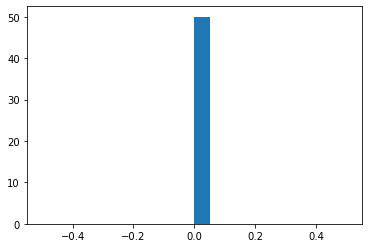

In [124]:
dfa4 = df[df.Acqu==4].copy()
dfa4f2 = dfa4[dfa4.Filter=="THIRD"].copy()
my_list = []
for i in range(len(dfa4f2)):
    projection = dfa4f2.iloc[i].Image_processed_masked[int(dfa4.iloc[i].muV),:]
    unique, counts = np.unique(projection, return_counts=True)
    my_dict = dict(zip(unique, counts))
    try:
        my_list.append(my_dict[255])
    except:
        my_list.append(0)
fig, ax = plt.subplots()
ax.hist(my_list, bins = 20)

# fit on the projection

Text(0.5, 0.98, 'Filter: THIRD')

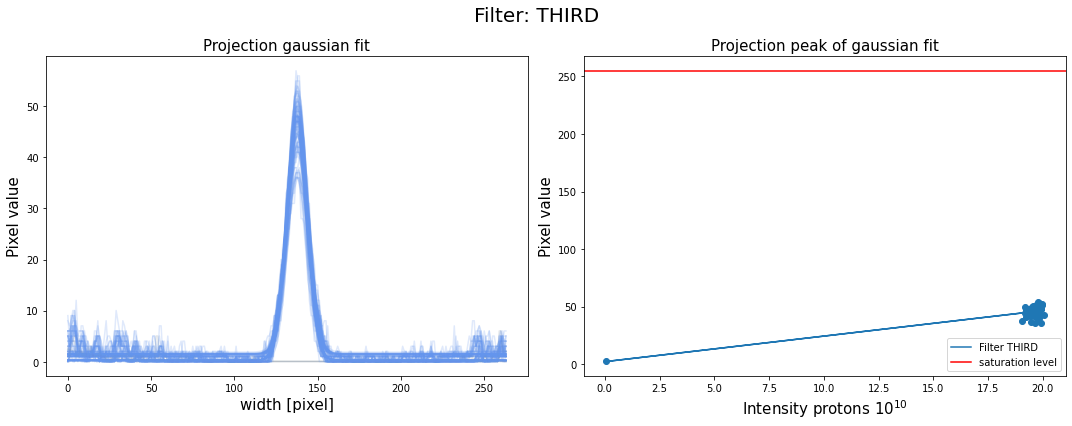

In [125]:
fig, ax = plt.subplots(1,2, figsize=(15,6), tight_layout=True)
Filter="THIRD"

gauss_max_list = []
intensity_list = []

dfa4f2 = dfa4[dfa4.Filter==Filter].copy()
for i in range(len(dfa4f2)):
    
    if (dfa4f2.iloc[i].Intensity < 15):
        c1 = "slategray"
        c2 = "salmon"
    if ((dfa4f2.iloc[i].Intensity > 15) and (dfa4.iloc[i].Intensity < 25)):
        c1 = "cornflowerblue"
        c2 = "tomato"
    if (dfa4f2.iloc[i].Intensity > 25 and dfa4.iloc[i].Intensity < 35):
        c1 = "blue"
        c2 = "red"
    if (dfa4f2.iloc[i].Intensity > 35):
        c1 = "darkblue"
        c2 = "darkred"

    ax[0].plot(dfa4f2.iloc[i].Image_processed[:,int(dfa4f2.iloc[i].muH)], alpha = 0.2, color=c1)
#     ax.plot(dfa4f2.iloc[i].Image_processed[int(dfa4f2.iloc[i].muV),:], alpha = 0.2)

    Hx = np.linspace(0,263,264)
    Hy = dfa4f2.iloc[i].Image_processed[:,int(dfa4f2.iloc[i].muH)]
    
    try:
        popt, pcov = do_gaussian_fit(Hx, Hy)
        gaussian_max = gaussian_function(Hx, popt[0], popt[1], popt[2], popt[3]).max()
        gauss_max_list.append(gaussian_max)
        intensity_list.append(dfa4f2.iloc[i].Intensity)
        
        ax[0].plot(Hx, gaussian_function(Hx, popt[0], popt[1], popt[2], popt[3]), alpha=0.2, color=c1)
    except:
        pass

    
ax[0].set_ylabel("Pixel value", fontsize=15)
ax[0].set_xlabel("width [pixel]", fontsize=15)
ax[0].set_title("Projection gaussian fit", fontsize=15)

ax[1].scatter(intensity_list, gauss_max_list)
res = stats.linregress(intensity_list, gauss_max_list)
ax[1].plot(intensity_list, res.intercept + res.slope*np.array(intensity_list), label = f"Filter {Filter}")
ax[1].axhline(255, color="r", label="saturation level")

ax[1].set_xlabel("Intensity protons $10^{10}$", fontsize=15)
ax[1].set_ylabel("Pixel value", fontsize=15)
ax[1].set_title("Projection peak of gaussian fit", fontsize=15)
ax[1].legend()
fig.suptitle(f"Filter: {Filter}", fontsize=20)

# Create a column with saturation in projection

In [126]:
# In H
saturation_projection_list = []
ok = False
for i in range(len(df)):
    
    try:
        projection = df.iloc[i].Image_processed_masked[:,int(df.iloc[i].muH)]
        unique, counts = np.unique(projection, return_counts=True)
        my_dict = dict(zip(unique, counts))
        ok = True
    except:
        print("found a NaN")
        saturation_projection_list.append(np.nan)
    if (ok == True):
        try:
            saturation_projection_list.append(my_dict[255])
        except:
            saturation_projection_list.append(0)
#             print("not saturated")
    ok = False
# print (saturation_projection_list)
df["Saturation_projectionH"] = saturation_projection_list

found a NaN
found a NaN
found a NaN
found a NaN
found a NaN
found a NaN


In [127]:
# In V
saturation_projection_list = []
ok = False
for i in range(len(df)):
    
    try:
        projection = df.iloc[i].Image_processed_masked[int(df.iloc[i].muV),:]
        unique, counts = np.unique(projection, return_counts=True)
        my_dict = dict(zip(unique, counts))
        ok = True
    except:
        print("found a NaN")
        saturation_projection_list.append(np.nan)
    if (ok == True):
        try:
            saturation_projection_list.append(my_dict[255])
        except:
            saturation_projection_list.append(0)
#             print("not saturated")
    ok = False
# print (saturation_projection_list)
df["Saturation_projectionV"] = saturation_projection_list

found a NaN
found a NaN
found a NaN
found a NaN
found a NaN
found a NaN


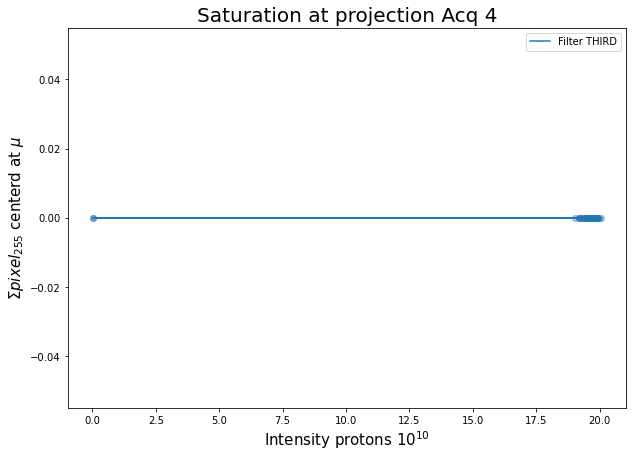

In [128]:
dfa4 = df[df.Acqu==4].copy()
filter_list = ["THIRD"]

fig, ax = plt.subplots(figsize=(10,7))
for Filter in filter_list:
    dfa4f2 = dfa4[dfa4.Filter==Filter].copy()
    
    ax.scatter(dfa4f2.Intensity, dfa4f2.Saturation_projectionH + dfa4f2.Saturation_projectionV, alpha=0.4)
    
    res = stats.linregress(dfa4f2.Intensity, dfa4f2.Saturation_projectionH + dfa4f2.Saturation_projectionV)
    ax.plot(dfa4f2.Intensity, res.intercept + res.slope*dfa4f2.Intensity, label = f"Filter {Filter}")
ax.set_xlabel("Intensity protons $10^{10}$", fontsize=15)
ax.set_ylabel("$\Sigma pixel_{255}$ centerd at $\mu$", fontsize=15)
ax.set_title("Saturation at projection Acq 4", fontsize=20)
ax.legend()

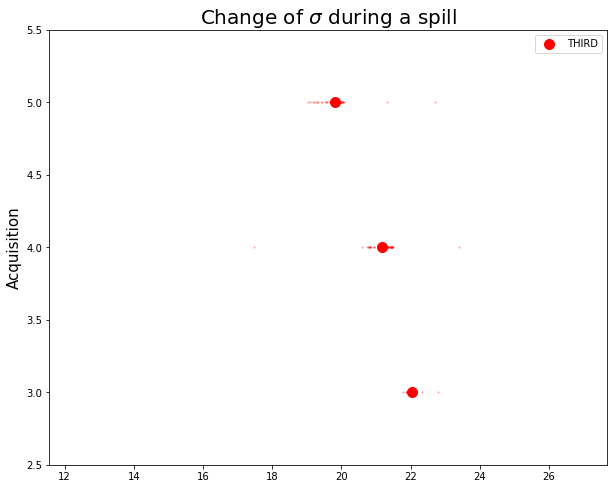

In [129]:
fig, ax = plt.subplots(figsize=(10,8))

color_list = ["r","b","g","orange"]
value=0

for Filter in ["THIRD"]:
    for acq in range(6):

        df_filter = df[df.Filter==Filter].copy()
        df_acqu = df_filter[df_filter.Acqu==acq].copy()
        

        beam_size_list = []
        acq_list = []

        for i in range(len(df_filter)):
            try:
                beam_size_list.append(df_acqu.iloc[i].poptH2_cal)
                acq_list.append(df_acqu.iloc[i].Acqu)
            except:
                pass

        ax.scatter(beam_size_list, np.ones(len(beam_size_list))*acq, s=2, alpha=0.2, color=color_list[value])
        if acq==0:
            my_label=Filter
        else:
            my_label=""
        ax.scatter(np.array(beam_size_list).mean(), acq, color=color_list[value], s=100, label = my_label, zorder=99)
    value +=1
ax.set_ylim(2.5,5.5)
# ax.set_xlabel("$\overline{\sigma^{H}}$ [mm]", fontsize=15)
ax.set_ylabel("Acquisition", fontsize=15)
ax.set_title("Change of $\sigma$ during a spill", fontsize=20)
ax.legend()

/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


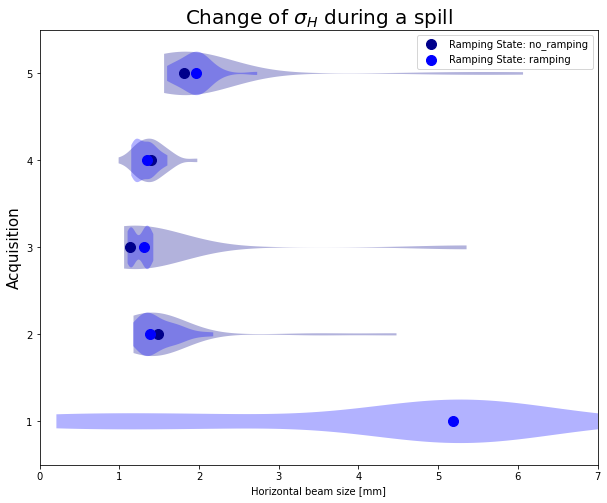

In [136]:
fig, ax = plt.subplots(figsize=(10,8))

color_list = ["darkblue","blue","cornflowerblue","slategray"]
value=0

for Ramping in ["no_ramping", "ramping"]:
    for acq in range(6):

        df_ramping = df[df.ramping==Ramping].copy()
        df_acqu = df_ramping[df_ramping.Acqu==acq].copy()
        

        beam_size_list = []
        acq_list = []

        for i in range(len(df_ramping)):
            try:
                beam_size_list.append(df_acqu.iloc[i].poptH3_cal)
                acq_list.append(df_acqu.iloc[i].Acqu)
            except:
                pass

#         ax.scatter(beam_size_list, np.ones(len(beam_size_list))*acq, s=2, alpha=0.2, color=color_list[value], zorder=99)
        if acq==0:
            my_label="Ramping State: "+str(Ramping)
        else:
            my_label=""
        ax.scatter(np.median(np.array(beam_size_list)), acq, color=color_list[value], s=100, label = my_label, zorder=99)
        violin_parts = ax.violinplot(beam_size_list, [acq], vert=False, showextrema=False, showmedians=False)
        
        for pc in violin_parts['bodies']:
            pc.set_facecolor(color_list[value])
            pc.set_edgecolor(None)
        
    value +=1
ax.set_ylim(0.5,5.5)
ax.set_xlim(0, 7)
# ax.set_xlabel("$\overline{\sigma^{H}}$ [mm]", fontsize=15)
ax.set_ylabel("Acquisition", fontsize=15)
ax.set_xlabel("Horizontal beam size [mm]")
ax.set_title("Change of $\sigma_{H}$ during a spill", fontsize=20)
ax.legend()

/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


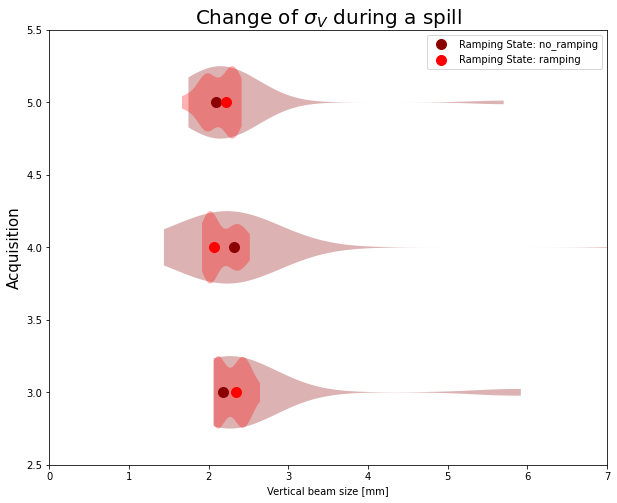

In [135]:
fig, ax = plt.subplots(figsize=(10,8))

color_list = ["darkred","red","tomato","salmon"]
value=0

for Ramping in ["no_ramping", "ramping"]:
    for acq in range(6):

        df_ramping = df[df.ramping==Ramping].copy()
        df_acqu = df_ramping[df_ramping.Acqu==acq].copy()
        

        beam_size_list = []
        acq_list = []

        for i in range(len(df_ramping)):
            try:
                beam_size_list.append(df_acqu.iloc[i].poptV3_cal)
                acq_list.append(df_acqu.iloc[i].Acqu)
            except:
                pass

#         ax.scatter(beam_size_list, np.ones(len(beam_size_list))*acq, s=2, alpha=0.2, color=color_list[value], zorder=99)
        if acq==0:
            my_label="Ramping State: "+str(Ramping)
        else:
            my_label=""
        ax.scatter(np.median(np.array(beam_size_list)), acq, color=color_list[value], s=100, label = my_label, zorder=99)
        violin_parts = ax.violinplot(beam_size_list, [acq], vert=False, showextrema=False, showmedians=False)
        
        for pc in violin_parts['bodies']:
            pc.set_facecolor(color_list[value])
            pc.set_edgecolor(None)
        
    value +=1
ax.set_ylim(2.5,5.5)
ax.set_xlim(0,7)
# ax.set_xlabel("$\overline{\sigma^{H}}$ [mm]", fontsize=15)
ax.set_ylabel("Acquisition", fontsize=15)
ax.set_xlabel("Vertical beam size [mm]")
ax.set_title("Change of $\sigma_{V}$ during a spill", fontsize=20)
ax.legend()

/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


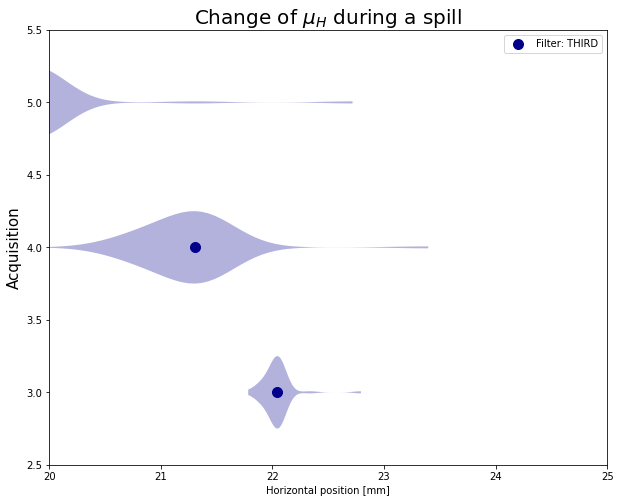

In [132]:
fig, ax = plt.subplots(figsize=(10,8))

color_list = ["darkblue","blue","cornflowerblue","slategray"]
value=0

for Filter in ["THIRD"]:
    for acq in range(6):

        df_filter = df[df.Filter==Filter].copy()
        df_acqu = df_filter[df_filter.Acqu==acq].copy()
        

        beam_size_list = []
        acq_list = []

        for i in range(len(df_filter)):
            try:
                beam_size_list.append(df_acqu.iloc[i].poptH2_cal)
                acq_list.append(df_acqu.iloc[i].Acqu)
            except:
                pass

#         ax.scatter(beam_size_list, np.ones(len(beam_size_list))*acq, s=2, alpha=0.2, color=color_list[value], zorder=99)
        if acq==0:
            my_label="Filter: "+str(Filter)
        else:
            my_label=""
        ax.scatter(np.median(np.array(beam_size_list)), acq, color=color_list[value], s=100, label = my_label, zorder=99)
        violin_parts = ax.violinplot(beam_size_list, [acq], vert=False, showextrema=False, showmedians=False)
        
        for pc in violin_parts['bodies']:
            pc.set_facecolor(color_list[value])
            pc.set_edgecolor(None)
        
    value +=1
ax.set_ylim(2.5,5.5)
ax.set_xlim(20, 25)
# ax.set_xlabel("$\overline{\sigma^{H}}$ [mm]", fontsize=15)
ax.set_ylabel("Acquisition", fontsize=15)
ax.set_xlabel("Horizontal position [mm]")
ax.set_title("Change of $\mu_{H}$ during a spill", fontsize=20)
ax.legend()

/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


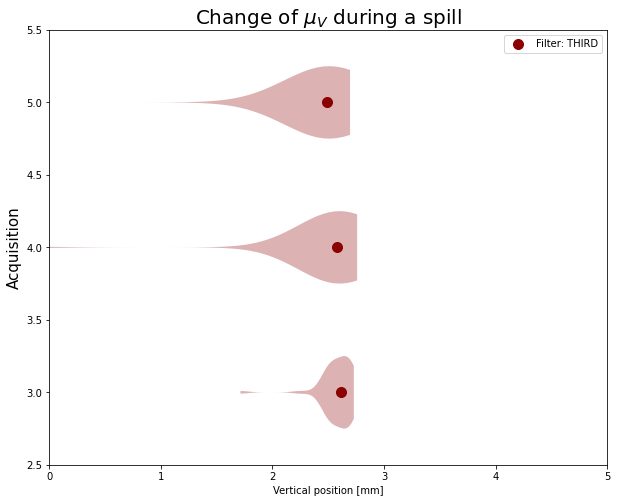

In [133]:
fig, ax = plt.subplots(figsize=(10,8))

color_list = ["darkred","red","tomato","salmon"]
value=0

for Filter in ["THIRD"]:
    for acq in range(6):

        df_filter = df[df.Filter==Filter].copy()
        df_acqu = df_filter[df_filter.Acqu==acq].copy()
        

        beam_size_list = []
        acq_list = []

        for i in range(len(df_filter)):
            try:
                beam_size_list.append(df_acqu.iloc[i].poptV2_cal)
                acq_list.append(df_acqu.iloc[i].Acqu)
            except:
                pass

#         ax.scatter(beam_size_list, np.ones(len(beam_size_list))*acq, s=2, alpha=0.2, color=color_list[value], zorder=99)
        if acq==0:
            my_label="Filter: "+str(Filter)
        else:
            my_label=""
        ax.scatter(np.median(np.array(beam_size_list)), acq, color=color_list[value], s=100, label = my_label, zorder=99)
        violin_parts = ax.violinplot(beam_size_list, [acq], vert=False, showextrema=False, showmedians=False)
        
        for pc in violin_parts['bodies']:
            pc.set_facecolor(color_list[value])
            pc.set_edgecolor(None)
        
    value +=1
ax.set_ylim(2.5,5.5)
ax.set_xlim(0,5)
# ax.set_xlabel("$\overline{\sigma^{H}}$ [mm]", fontsize=15)
ax.set_ylabel("Acquisition", fontsize=15)
ax.set_xlabel("Vertical position [mm]")
ax.set_title("Change of $\mu_{V}$ during a spill", fontsize=20)
ax.legend()